# Multiple Linear Regression to predict fish weight

### About the Data Set

This dataset is a record of 7 common different fish species, their weights, lengths, heights, and widths. 

Species: Species name of fish

Weight: Weight of fish in gram

Length1: Vertical length in cm

Length2: Diagonal length in cm

Length3: Cross length in cm

Height: Height in cm

Width: Diagonal width in cm

#### The purpose of this notebook is to create a model which can predict fish weight.

https://www.kaggle.com/datasets/aungpyaeap/fish-market?resource=download

### About Multiple Lienar Regression

Multiple (or single variable) linear regression, allows us to predict our predictor variable based on the values of one or more independent variables by minimizing the residual sum of squares (RSS) and fitting the best line or hyperplane to the data. 

$ \hat{y} = b_1 * x_1 + b_2 * x_2... b_k * x_k $

$ RSS = \sum \limits _{i} ^{n}(y_i- \hat{y}_i)^2 $

After generating the coefficients of the model to predict $ \hat{y} $ , we find $ R $  which measures the correlation between the predictor variable and the indepedent variables. Then, we can use adjusted $ R^2 $ to see how much the predictor variable can be explained the the independent variables. We must use adjusted $ R^2 $ because $ R^2 $ overestimates when multiple independent variables are used. Next, we must interpret the standard estimation error, which tells us, on average, how much the model overestimates the predictor variable. 

Next, we must statistically verify our model. We can use an F-test to test the null hypothesis, which is that all coeffients are 0, i.e. they have no affect on the predictor variable. 

Lastly, we must look at the standardized coeffieints' beta values to see which independent variables have the most influence on our predictor variable. We also need to check the p-value for statistical significance. 

#### Assumptions for multiple linear regression
1. Must be linear relationship between dependent and independent variables.
2. Independent variables must follow a normal distribution
3. No multicollinearity (if there is it means coefficients are unstbale)
4. Little or no autocorrelation (residuals are independent)
5. Data is homoscedastic (the error along the regression line are equal)

### Exploratory Data Analysis

In [74]:
# Import required libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn import linear_model

# Import Dataset 
fish_df = pd.read_csv('Fish.csv')
print(fish_df.sample(5))
# Check for Null
print(fish_df.isnull().sum())

       Species  Weight  Length1  Length2  Length3   Height   Width
148      Smelt     9.7     10.4     11.0     12.0   2.1960  1.3800
13       Bream   340.0     29.5     32.0     37.3  13.9129  5.0728
89       Perch   135.0     20.0     22.0     23.5   5.8750  3.5250
58   Whitefish   540.0     28.5     31.0     34.0  10.7440  6.5620
48       Roach   169.0     22.0     24.0     27.2   7.5344  3.8352
Species    0
Weight     0
Length1    0
Length2    0
Length3    0
Height     0
Width      0
dtype: int64


In [75]:
# We have no null values, but the column length names are difficult to understand. 
# Renaming columns based on definition in Kaggle dataset

fish_df.rename(columns={'Length1': 'vertical_len', 'Length2': 'diagonal_len', 'Length3': 'cross_len'}, inplace=True)

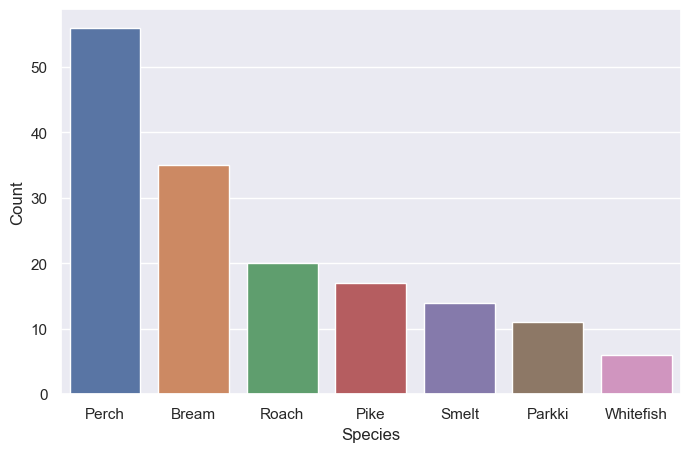

In [76]:
# Check species distribution in dataset

# Create dataframe for species counts
species = fish_df['Species'].value_counts()
species = pd.DataFrame(species)

# Plot
sns.barplot(x=species.index, y=species['Species'])
#sns.set(rc={'figure.figsize':(8,5)})
plt.xlabel('Species')
plt.ylabel('Count')
plt.show()


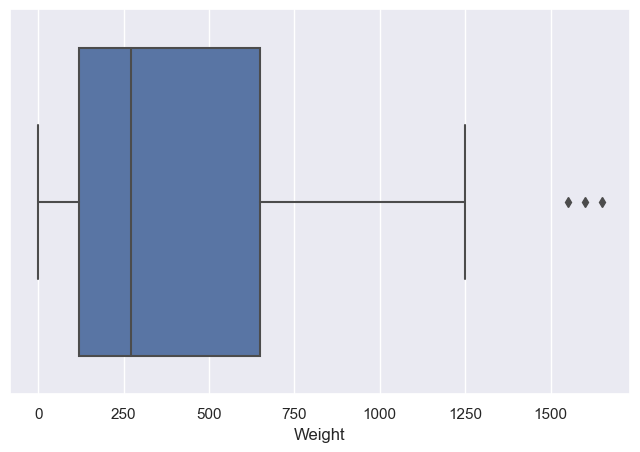

In [77]:
sns.boxplot(x=fish_df['Weight']);

In [78]:
# Find Outliers using Interquartile range method
weights = fish_df['Weight'] 
weights_Q1 = weights.quantile(0.25)
weights_Q3 = weights.quantile(0.75)
IQR = weights_Q3 - weights_Q1
upper_fence = weights_Q3 + (1.5 * IQR)
lower_fence = weights_Q1 - (1.5 * IQR)

outliers = weights[(weights<lower_fence) | (weights>upper_fence)]
print(outliers)


142    1600.0
143    1550.0
144    1650.0
Name: Weight, dtype: float64


In [79]:
# Remove outliers from dataset
fish_df = fish_df.drop([142,143,144])

In [80]:
fish_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Weight,156.0,375.217308,319.546978,0.0000,120.000000,271.0000,612.500000,1250.000
vertical_len,156.0,25.655769,9.119630,7.5000,19.000000,25.0000,32.125000,52.000
diagonal_len,156.0,27.786538,9.792651,8.4000,21.000000,26.7500,35.000000,56.000
cross_len,156.0,30.571154,10.695359,8.8000,23.025000,29.2500,39.425000,59.700
Height,156.0,8.951128,4.324325,1.7284,5.931675,7.6478,12.378550,18.957
Width,156.0,4.375719,1.672188,1.0476,3.369600,4.2433,5.424375,8.142


Now, we will check that are dataset meets all the assumptions for multilinear regression.

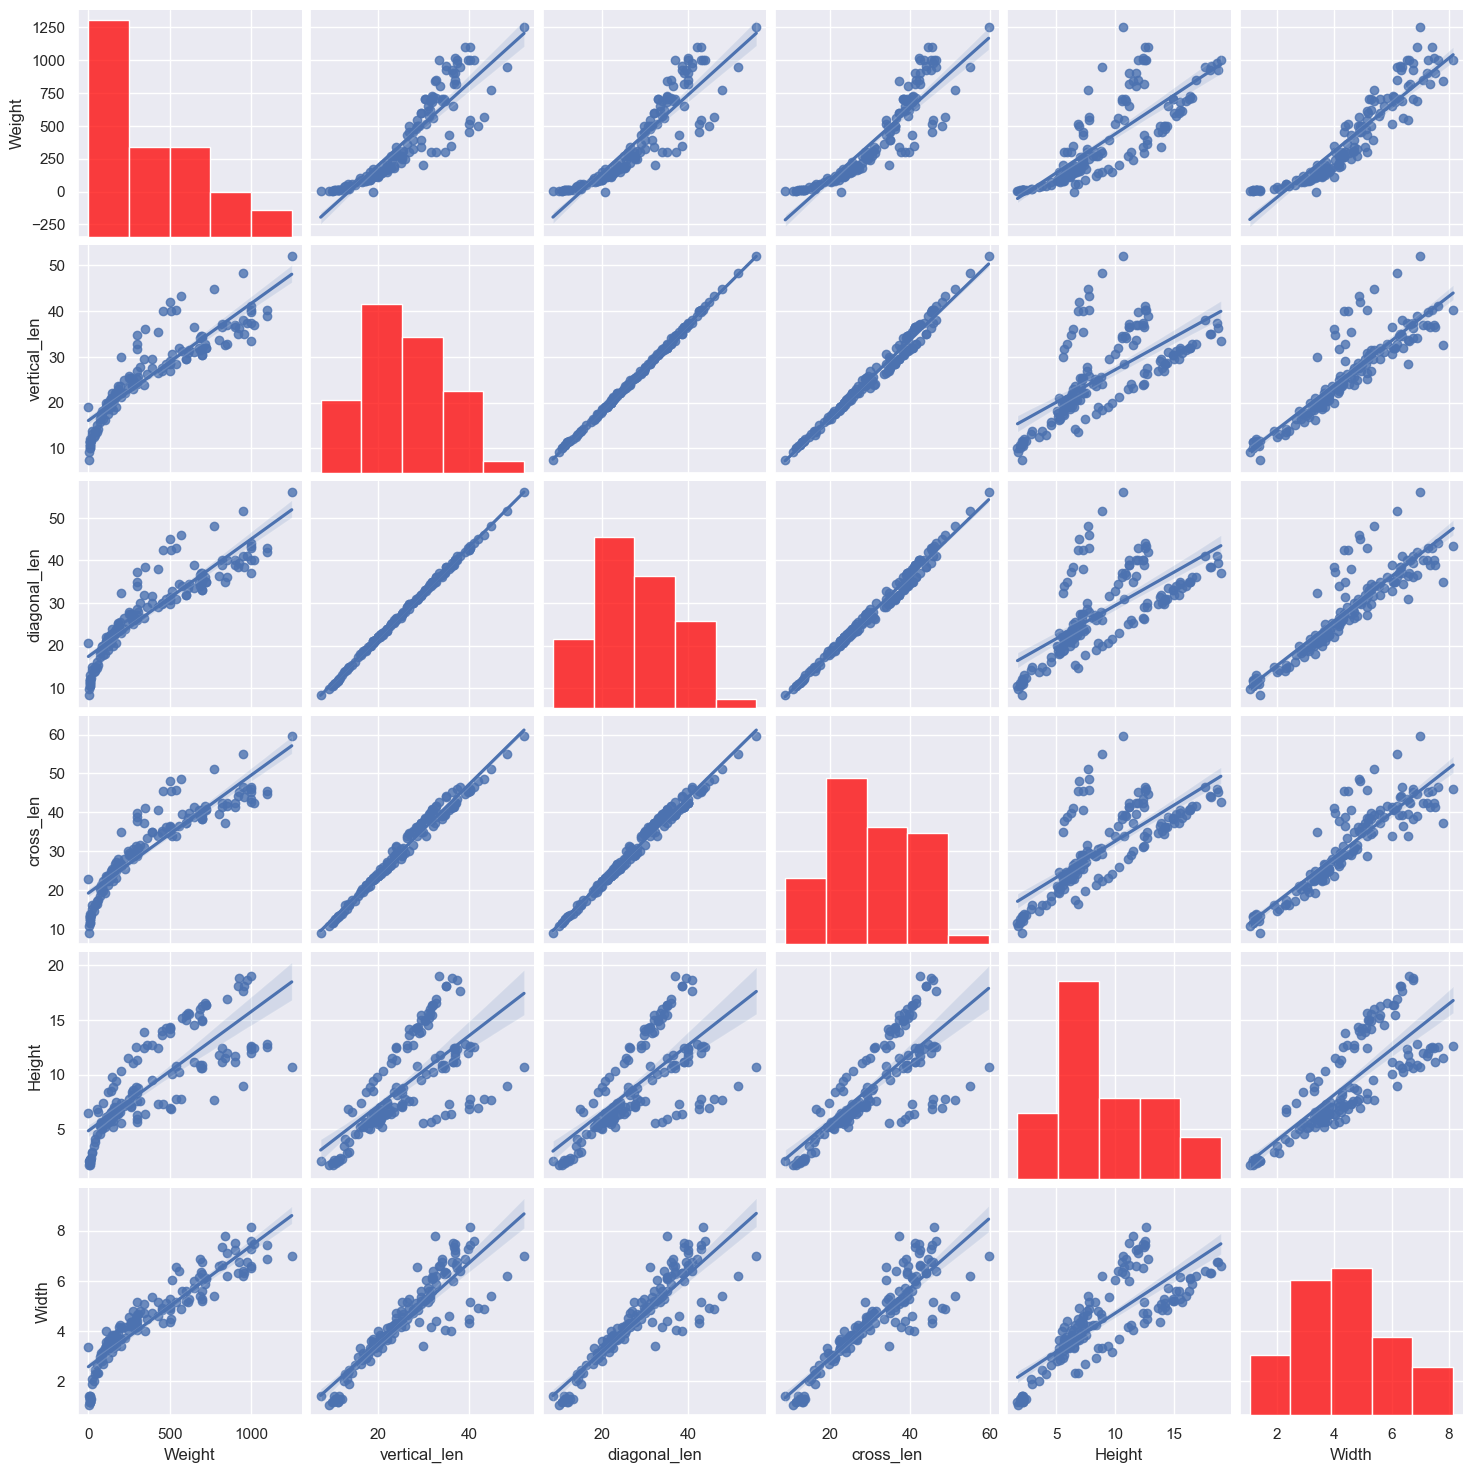

In [81]:
pair_plot = sns.pairplot(fish_df, kind='reg', diag_kws={'color':'red', 'bins':5});
# hue='Species',


1. Must be linear relationship between dependent and independent variables.

    If we look at the first row of the pairplot, we can see that all our dependent variables correlate linearly to the independet variable (weight). 

2.  Independent variables must follow a normal distribution

    If we look at the histograms in the pairplot, we can see the independent variables are normally distributed. 


In [82]:
# Test for multicollinearity by calculating the variance inflation factor (VIF)
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Design matrix for regression model using 'Weight' as response variable
y, X = dmatrices('Weight~vertical_len+diagonal_len+cross_len+Height+Width'
                 , data=fish_df, return_type='dataframe')

# Create dataframe for VIF values
vif_df = pd.DataFrame()
vif_df['variable'] = X.columns

# Calculate VIF for each predictor variable
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df)

       variable          VIF
0     Intercept    10.058286
1  vertical_len  1402.034124
2  diagonal_len  1735.063137
3     cross_len   357.013781
4        Height    15.034860
5         Width    12.511646


3. No multicollinearity (if there is it means coefficients are unstbale)

    As we can see from the VIF test, the predictor variables are highly correlated. We can also vizualize this in the pairplots between predictor variables. This indicates that multicollinearity is a problem in this model. 

    It makes sense that all the lengths are highly correlated to each other, because fish of different species probably have the same proportions in the different lengths. Furthermore, any one of these variables alone will suffice to predict weight. 

    In the last section, we will compare this model to a single regression model and compare the fit of both models. We will also discuss costs/benefits of multiple vs. single variable linear regression.


In [83]:
# Durbin-Watson test for autocorerlation
from statsmodels.formula.api import ols
from statsmodels.stats.stattools import durbin_watson

#fit multiple linear regression model
model = ols('Weight~vertical_len+diagonal_len+cross_len+Height+Width', data=fish_df).fit()

#perform Durbin-Watson test
durbin_watson(model.resid)

0.5268759589680917

4. Little or no autocorrelation (residuals are independent)
    Becuase of the high correlation of the predictor variables, it follows that the Durbin-Watson tests indicates autocorrelation between the residules. 

    A value of 1.5-2.5 is considered normal. However, our dataset indicates a Durbin-Watson value of 0.5. 


c:\Users\71062489\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Homoscedasticity')

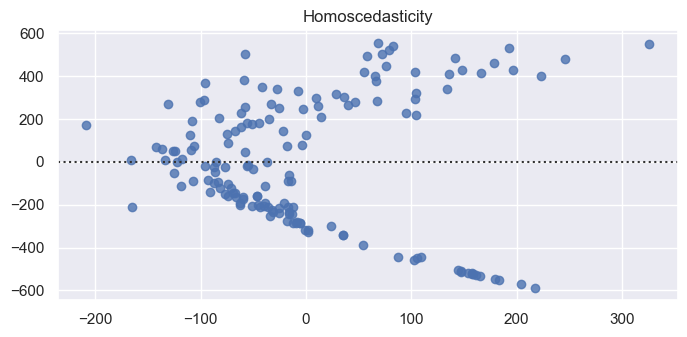

In [84]:
# Test for homoscedasticity 
import matplotlib.pyplot as plt

# Homoscedasticity
reg=ols('Weight~vertical_len+diagonal_len+cross_len+Height+Width', data=fish_df).fit()

#Plot
fig, ax=plt.subplots(figsize=(8,3.5))
pred_val=reg.fittedvalues.copy()
true_val=fish_df['Weight'].values.copy()
resid = true_val-pred_val
res = sns.residplot(resid,pred_val)
plt.title("Homoscedasticity")


5. Data is homoscedastic (the error along the regression line are equal)

    We see that the data is not homoscedastic, as it creates a cone shape. This indicates that OLS linear regression analysis will be inaccurate due to the greater variability in values across the higher ranges. 

### Summary of EDA

As our data failed 3 out of the 5 assumption tests for multiple linear regression. Therefore, it appears that simple linear regression will suffice. 

The following sections will perform multiple linear regression and simple linear regression. Then we will compare the results. 

### Multivariable Regression


In [99]:
# Create training and test sets 
from sklearn.model_selection import train_test_split

# Dependant (Target) Variable:
y = fish_df['Weight']
# Independant Variables:
X = fish_df[['Height', 'Width', 'vertical_len']].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [100]:
# Create multiple linear regression model
multi_reg = linear_model.LinearRegression()
multi_reg.fit(X_train, y_train)

LinearRegression()

In [101]:
# Parameters:
print('Model intercept: ', multi_reg.intercept_)
print('Model coefficients: ', multi_reg.coef_)

Model intercept:  -465.9127835647266
Model coefficients:  [12.69305326 87.63544179 13.28843955]


In [107]:
from sklearn.metrics import mean_squared_error, r2_score
multi_pred = multi_reg.predict(X_train)
print('R^2:', r2_score(y_train, multi_pred))

R^2: 0.9041933991977306


In [119]:
# Using trained model to estimate weights in the test set
y_prediction = reg.predict(X_test)
print(r2_score(y_test, y_prediction))

0.855262744626755


### Single Variable Regression

In [127]:
# Create training and test sets 
# Dependant (Target) Variable:
y = fish_df['Weight']
# Independant Variables:
X = fish_df[['Width']].copy()

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.2, random_state=1)

In [137]:
# Create single linear regression model with training set
sing_reg = linear_model.LinearRegression()
sing_reg.fit(X_train_2, y_train_2)

r_sq = sing_reg.score(X_train_2, y_train_2)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {sing_reg.intercept_}")
print(f"slope: {sing_reg.coef_}")

coefficient of determination: 0.8644069724297607
intercept: -398.16151222065685
slope: [176.39044528]


In [140]:
# Predict weights with test set
sing_pred = sing_reg.predict(X_test_2)
print(r2_score(y_test_2, sing_pred))


0.8042883565793671


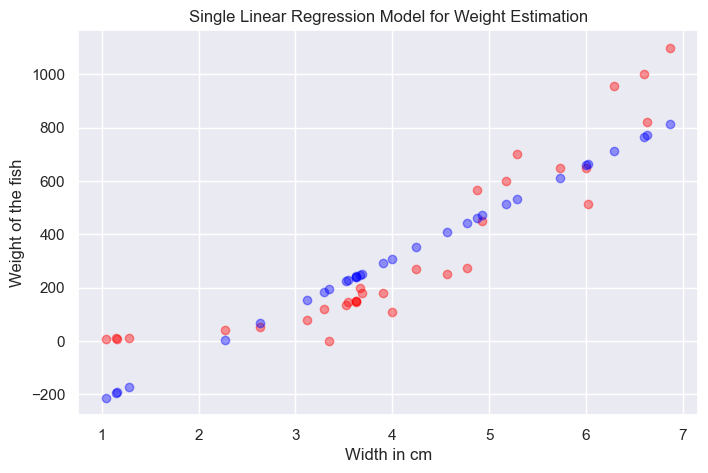

In [143]:
# Create Vizualization
plt.scatter(X_test_2['Width'], y_test_2, color='red', alpha=0.4)
plt.scatter(X_test_2['Width'], sing_pred, color='blue', alpha=0.4)
plt.xlabel('Width in cm')
plt.ylabel('Weight of the fish')
plt.title('Single Linear Regression Model for Weight Estimation');

### Conclusion: Multivariable vs. Singular Regression

After performing multivariable and single variable linear regression, it is apparent that the single variable regression performs just as well to predict fish weight, with R^2 of 86%. 

This was expected because our dataset could not meet the assumptions for multivariable linear regression. Therefore, single linear regression could suffice. 

The relationships between these variables were quite simple and straightforward. That is why single linear regression was sufficient. When the data becomes more complex, multivariable regression is more suitable. 

As Multivariable regression is more intensive than single linear regression, it is imperative to first verify the assumptions so as not to overcomplicate the model unnecessarily. 